In [1]:
import tifffile as tfile
import matplotlib.pyplot as plt


In [2]:
image = tfile.imread('./RawTest.tif')
psf = tfile.imread('./mRuby3_0.3.tif')

In [2]:
#pycudadecon shares VRAM and RAM when needed, no need to split images, and we don't mind going slow for this.
from pycudadecon import decon
resultpycuda = decon(image, psf)
tfile.imwrite('./pycudadecon.tif',resultpycuda)

[[[1.70268294e-07 4.13680326e-08 1.04019641e-07 ... 1.04019641e-07
   4.13680326e-08 1.70268294e-07]
  [4.13680326e-08 1.05331864e-07 1.66438511e-07 ... 1.66438511e-07
   1.05331864e-07 4.13680326e-08]
  [1.04019641e-07 1.66438511e-07 2.56057913e-08 ... 2.56057913e-08
   1.66438511e-07 1.04019641e-07]
  ...
  [1.04019641e-07 1.66438511e-07 2.56057913e-08 ... 2.56057913e-08
   1.66438511e-07 1.04019641e-07]
  [4.13680326e-08 1.05331864e-07 1.66438511e-07 ... 1.66438511e-07
   1.05331864e-07 4.13680326e-08]
  [1.70268294e-07 4.13680326e-08 1.04019641e-07 ... 1.04019641e-07
   4.13680326e-08 1.70268294e-07]]

 [[1.73171230e-07 4.52068392e-08 1.05016966e-07 ... 1.05016966e-07
   4.52068392e-08 1.73171230e-07]
  [4.52068392e-08 1.06337666e-07 1.69879542e-07 ... 1.69879542e-07
   1.06337666e-07 4.52068392e-08]
  [1.05016966e-07 1.69879542e-07 2.96230045e-08 ... 2.96230045e-08
   1.69879542e-07 1.05016966e-07]
  ...
  [1.05016966e-07 1.69879542e-07 2.96230045e-08 ... 2.96230045e-08
   1.69879

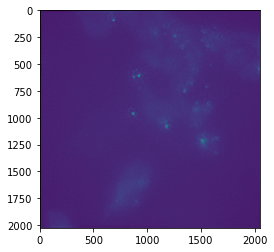

In [3]:
plt.imshow(resultpycuda[5])

In [3]:
from flowdec import restoration as fd_restoration
from flowdec import data as fd_data
from flowdec import psf as fd_psf
import dask
import dask.array as da
# from nd2reader import ND2Reader
# import pims

def init_RL_algo(psfdims,pad_mode='none',pad_min=(0,0,0)):
    algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=psfdims
                                                    , pad_mode=pad_mode
                                                    ,pad_min=pad_min
    #                                                     ,observer_fn=observer
#                                                     ,device='/cpu:0'
                                                   ).initialize()
    return algo

def deconv(chunk, algo, psf, iters=10,hostRAM=False):
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    if hostRAM:
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 2
#     session = InteractiveSession(config=config)
    tmp = algo.run(fd_data.Acquisition(data=chunk, kernel=psf)
                                , session_config = config
                                ,niter=iters
                               )
    return tmp.data

In [4]:
ydivide = 2
xdivide = 2

if xdivide >1 and ydivide >1:
    depthdivide = (0,62,64)
elif xdivide > 1 and ydivide == 1:
        depthdivide = (0,0,64)
else:
        depthdivide = (0,0,0)
image.shape
chunk_size=(39,2044//ydivide,2048//xdivide)

In [5]:
#I am using CPU not to have to split the image with dask just for this example (The result is the same, but slower)
#In this example it's run in a conda env with tensorflow-gpu==1.14.0, It was also tested with tensorflow==2.2.0 with the same result
algo =init_RL_algo(psf.ndim)

arr = da.from_array(image
#                                         [:,0:2044,0:2044]
#                                     [:,:,:]              
                    , chunks=chunk_size)

result_flowdec = da.map_overlap(deconv, arr , depth  = depthdivide ,boundary='reflect'
                            ,dtype='float32', algo=algo, psf=psf, iters=10).compute(num_workers=1)
        #                     res[i,:,:,:] = arr.map_blocks(

In [10]:
from numba import cuda
cuda.select_device(0)
cuda.close()
#the memory was released here!
cuda.select_device(0)

<weakproxy at 0x7fac3d6f4cb0 to Device at 0x7fac3dc33190>

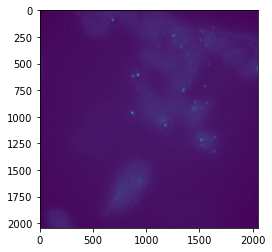

In [26]:
tfile.imwrite('./flowdec.tif',result_flowdec)
plt.imshow(result_flowdec[12])

In [14]:
image.shape

(39, 2044, 2048)

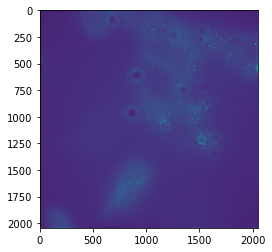

In [30]:
result_fiji = tfile.imread('./fiji.tif')
plt.imshow(result_fiji[5])
# result_nikon = tfile.imread('./nikon.tif')


In [32]:
import napari
# from napari.qt import thread_worker

with napari.gui_qt():
    v = napari.Viewer(show=False)
    v.show()
    v.add_image(
            result_flowdec,
#             blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
    #         ndisplay=2,
            colormap='gray',
            name='Flowdec'
        )   
    v.add_image(
            resultpycuda,
#             blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
    #         ndisplay=2,
            colormap='gray',
            name='Pycudadecon'
        )   
    v.add_image(
            result_fiji,
#             blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
    #         ndisplay=2,
            colormap='gray',
            name='Deconvolution Lab 2 with Fiji'
        )   
#     v.add_image(
#             result_nikon,
# #             blending='additive',
#     #         contrast_limits=[np.min(result[1]),np.max(result[1])],
#     #         ndisplay=2,
#             colormap='gray',
#             name='Nikon NIS-elements deconvolution'
#         )   